In [1]:
import pandas as pd
import numpy as np
import itertools
import mplfinance as mpf
import re
import math
from math import floor
import sys
import os

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import FunctionTransformer

In [34]:
df1 = pd.read_csv('df_final_part_1_log_returns.csv', dtype=None)
df2 = pd.read_csv('df_final_part_2_log_returns.csv', dtype=None)
df_final = pd.concat([df1, df2]).reset_index(drop=True)
df_final = df_final.replace([-np.inf], -1)

df_test = pd.read_csv('df_final_test.csv')
df_test = df_test[(df_test.year == 2023) & (df_test.month == 4) & (df_test.day > 14)]
df_test = df_test.replace([-np.inf], -1)

In [98]:
# Remove other columns that we dont need.
def remove_other_cols(X, y=None):
    other_cols = ['open_es', 'high_es', 'low_es', 'close_es', 'open_nq', 'high_nq', 'low_nq', 'close_nq', 'month', 'day', 'day_of_week_5']
    for col in other_cols:
        if col in X.columns:
            X = X.drop(columns=col)
    return X

target_cols = ['Morning_High', 'Morning_Low', 'Daily_High', 'Daily_Low']

X = df_final.drop(columns=target_cols)
y = df_final[target_cols]

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=2, random_state=42, shuffle=False)

# Create a pipeline for preprocessing and modeling
price_cols = [
    col for col in X.columns 
    if any(sub in col for sub in ['open', 'high', 'low', 'close', 'swing_', '_low', '_high']) 
    and not any(sub in col for sub in ['next'])
]

preprocessor = ColumnTransformer(
    transformers=[
        ('remove_cols', FunctionTransformer(remove_other_cols)),
        ('scaler', StandardScaler())
    ])

pipeline = Pipeline([
    ('remove_cols', FunctionTransformer(remove_other_cols)),
    ('scaler', StandardScaler()),
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),  # Impute any missing values after log transformation
    ('model', MultiOutputRegressor(RandomForestRegressor(n_estimators=100, max_features='sqrt', random_state=42, n_jobs=-1)))
])

# Fit pipeline to training data
pipeline.fit(X_train, y_train)

# Evaluate pipeline on test data
y_pred = pipeline.predict(X_test)

r2_scores = r2_score(y_test, y_pred, multioutput='raw_values')
mae_scores = mean_absolute_error(y_test, y_pred, multioutput='raw_values')
mse_scores = mean_squared_error(y_test, y_pred, multioutput='raw_values')
rmse_scores = np.sqrt(mse_scores)

for i, (target, r2, mae, mse, rmse) in enumerate(zip(target_cols, r2_scores, mae_scores, mse_scores, rmse_scores)):
    print(f'{target} metrics:')
    print(f'R^2 score: {r2:.6f}')
    print(f'MAE: {mae:.6f}')
    print(f'MSE: {mse:.6f}')
    print(f'RMSE: {rmse:.6f}\n')
    
os.system("printf '\a'") # or '\7'

Morning_High metrics:
R^2 score: -22.873259
MAE: 0.002080
MSE: 0.000006
RMSE: 0.002386

Morning_Low metrics:
R^2 score: -0.276927
MAE: 0.001046
MSE: 0.000002
RMSE: 0.001387

Daily_High metrics:
R^2 score: -1.773727
MAE: 0.004193
MSE: 0.000023
RMSE: 0.004838

Daily_Low metrics:
R^2 score: 0.378679
MAE: 0.001937
MSE: 0.000005
RMSE: 0.002132



0

In [99]:
###### FIT TO PAST TWO WEEKS OF DATA --- FORWARD TESTING ########

X_forward_test = df_test.drop(columns=target_cols)[X_train.columns] #rearrange columns to match the X_train ones...idk why they aren't in the same order
y_forward_test = df_test[target_cols]

# Evaluate pipeline on test data
y_pred = pipeline.predict(X_forward_test)

r2_scores = r2_score(y_forward_test, y_pred, multioutput='raw_values')
mae_scores = mean_absolute_error(y_forward_test, y_pred, multioutput='raw_values')
mse_scores = mean_squared_error(y_forward_test, y_pred, multioutput='raw_values')
rmse_scores = np.sqrt(mse_scores)

for i, (target, r2, mae, mse, rmse) in enumerate(zip(target_cols, r2_scores, mae_scores, mse_scores, rmse_scores)):
    print(f'{target} metrics:')
    print(f'R^2 score: {r2:.6f}')
    print(f'MAE: {mae:.6f}')
    print(f'MSE: {mse:.6f}')
    print(f'RMSE: {rmse:.6f}\n')
    
os.system("printf '\a'") # or '\7'

Morning_High metrics:
R^2 score: -0.041686
MAE: 0.002018
MSE: 0.000005
RMSE: 0.002328

Morning_Low metrics:
R^2 score: -0.723430
MAE: 0.002433
MSE: 0.000008
RMSE: 0.002908

Daily_High metrics:
R^2 score: 0.062730
MAE: 0.003456
MSE: 0.000017
RMSE: 0.004091

Daily_Low metrics:
R^2 score: -0.094712
MAE: 0.002959
MSE: 0.000013
RMSE: 0.003574



0

In [84]:
df_test.month

214    4
215    4
216    4
217    4
218    4
219    4
220    4
221    4
222    4
223    4
Name: month, dtype: int64

In [100]:
import pandas as pd

X_test = X_forward_test
y_test = y_forward_test


def get_most_accurate_predictions_combined_error(y_test, datetime_indexes, y_pred, target_names, N=10):
    # Calculate absolute errors for each target
    absolute_errors_target_1 = abs(y_test.iloc[:, 0] - y_pred[:, 0])
    absolute_errors_target_2 = abs(y_test.iloc[:, 1] - y_pred[:, 1])
    absolute_errors_target_3 = abs(y_test.iloc[:, 2] - y_pred[:, 2])
    absolute_errors_target_4 = abs(y_test.iloc[:, 3] - y_pred[:, 3])
    
    # Calculate combined absolute error
    combined_absolute_error_morning = -np.mean([absolute_errors_target_1, absolute_errors_target_2], axis=0)
    combined_absolute_error_daily = -np.mean([absolute_errors_target_3, absolute_errors_target_4], axis=0)

    # Create a DataFrame with datetime index, actual values, predicted values, and combined absolute error
    accuracy_df = pd.DataFrame({
        'datetime': datetime_indexes,
        'year': X_test.year,
        'month': df_test.month,
        'day': df_test.day,
        'open_es': df_test.open_es,
        f'a_{target_names[0]}': y_test.iloc[:, 0],
        f'p_{target_names[0]}': y_pred[:, 0],
        f'a_{target_names[1]}': y_test.iloc[:, 1],
        f'p_{target_names[1]}': y_pred[:, 1],
        f'a_{target_names[2]}': y_test.iloc[:, 2],
        f'p_{target_names[2]}': y_pred[:, 2],
        f'a_{target_names[3]}': y_test.iloc[:, 3],
        f'p_{target_names[3]}': y_pred[:, 3],
        'combined_error_morning': combined_absolute_error_morning,
        'combined_error_daily': combined_absolute_error_daily
    })
    
    accuracy_df['a_Daily_High'] = round(np.exp(accuracy_df['a_Daily_High']) * accuracy_df.open_es,2)
    accuracy_df['a_Daily_Low'] = round(np.exp(accuracy_df['a_Daily_Low']) * accuracy_df.open_es,2)
    accuracy_df['p_Daily_High'] = round(np.exp(accuracy_df['p_Daily_High']) * accuracy_df.open_es,2)
    accuracy_df['p_Daily_Low'] = round(np.exp(accuracy_df['p_Daily_Low']) * accuracy_df.open_es,2)
    accuracy_df['a_Morning_High'] = round(np.exp(accuracy_df['a_Morning_High']) * accuracy_df.open_es,2)
    accuracy_df['a_Morning_Low'] = round(np.exp(accuracy_df['a_Morning_Low']) * accuracy_df.open_es,2)
    accuracy_df['p_Morning_High'] = round(np.exp(accuracy_df['p_Morning_High']) * accuracy_df.open_es,2)
    accuracy_df['p_Morning_Low'] = round(np.exp(accuracy_df['p_Morning_Low']) * accuracy_df.open_es,2)
    accuracy_df['combined_error_morning'] = combined_absolute_error_morning
    accuracy_df['combined_error_daily'] = combined_absolute_error_daily
    
    return accuracy_df

# Example usage
target_names = target_cols

# Get the most accurate predictions based on the combined error (assuming y_test and y_pred are defined)
most_accurate_df = get_most_accurate_predictions_combined_error(y_test, y_test.index, y_pred, target_names, N=5)

# Display the results
print("Most accurate predictions based on combined error:")
#most_accurate_df.head(10)
most_accurate_df.sort_values(by=['year', 'month', 'day'], ascending=False).head(10)


Most accurate predictions based on combined error:


,datetime,year,month,day,open_es,a_Morning_High,p_Morning_High,a_Morning_Low,p_Morning_Low,a_Daily_High,p_Daily_High,a_Daily_Low,p_Daily_Low,combined_error_morning,combined_error_daily
223,223,2023,4,28,4146.25,4180.76,4166.94,4145.50,4128.00,4191.52,4169.15,4145.50,4127.64,-0.003771,-0.004834
222,222,2023,4,27,4100.00,4122.25,4119.47,4097.25,4080.68,4157.50,4122.97,4097.25,4078.56,-0.002363,-0.006456
221,221,2023,4,26,4100.00,4108.25,4121.82,4082.49,4081.45,4111.00,4122.39,4069.99,4081.76,-0.001777,-0.002827
220,220,2023,4,25,4140.25,4146.25,4156.03,4123.74,4119.29,4146.25,4160.14,4094.23,4122.85,-0.001718,-0.005155
219,219,2023,4,24,4153.25,4164.25,4167.49,4141.00,4134.13,4164.25,4173.16,4139.00,4135.26,-0.001220,-0.001521
218,218,2023,4,21,4156.25,4159.50,4172.82,4136.49,4134.32,4162.25,4179.96,4136.49,4137.62,-0.001861,-0.002258
217,217,2023,4,20,4146.75,4163.25,4167.47,4145.25,4127.45,4172.00,4167.37,4137.25,4129.13,-0.002658,-0.001537
216,216,2023,4,19,4157.00,4172.99,4174.88,4156.50,4138.46,4186.24,4178.19,4156.50,4138.21,-0.002400,-0.003167
215,215,2023,4,18,4193.50,4194.75,4208.84,4164.50,4175.61,4194.75,4214.69,4164.50,4175.17,-0.003008,-0.003650
214,214,2023,4,17,4161.00,4169.50,4176.79,4149.25,4144.22,4177.50,4180.02,4148.00,4144.96,-0.001480,-0.000668


In [ ]:
# JUST CHECKED THE DAILY HIGH AND LOW PREDITIONS. THEY SEEM WORSE THAN THE MORNING ONES...
####### THOUGHTS: 
# INCLUDE DAILY OPENING AT 12 MIDNIGHT
# PLOT WHAT THE DATA LOOKS LIKE FOR THE WORST AND BEST PREDICTIONS (FVG, SWINGS) TO SEE IF IT MAKES SENSE
# LSTM?

In [6]:
######### GRID SEARCH #########

param_grid = {
    'model__estimator__n_estimators': [5],  # Number of trees in the forest
    #'model__estimator__max_depth': [None, 10, 20],  # Maximum depth of the tree
    #'model__estimator__min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    #'model__estimator__min_samples_leaf': [1, 2, 4],  # Minimum number of samples required to be at a leaf node
    'model__estimator__max_features': np.arange(.1, 1, .1)  # Number of features to consider when looking for the best split
}
# Create the GridSearchCV object
grid_search = GridSearchCV(
    estimator=pipeline,  # MultiOutputRegressor with RandomForestRegressor
    param_grid=param_grid,
    scoring='neg_mean_absolute_error',
    cv=2,
    verbose=4,
    n_jobs=1
)

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_

# Get the best model
best_model = grid_search.best_estimator_

os.system("printf '\a'") # or '\7'

Fitting 2 folds for each of 9 candidates, totalling 18 fits
[CV 1/2] END model__estimator__max_features=0.1, model__estimator__n_estimators=5;, score=-0.003 total time=   0.7s
[CV 2/2] END model__estimator__max_features=0.1, model__estimator__n_estimators=5;, score=-0.003 total time=   0.7s
[CV 1/2] END model__estimator__max_features=0.2, model__estimator__n_estimators=5;, score=-0.002 total time=   1.0s
[CV 2/2] END model__estimator__max_features=0.2, model__estimator__n_estimators=5;, score=-0.003 total time=   1.1s
[CV 1/2] END model__estimator__max_features=0.30000000000000004, model__estimator__n_estimators=5;, score=-0.002 total time=   1.3s
[CV 2/2] END model__estimator__max_features=0.30000000000000004, model__estimator__n_estimators=5;, score=-0.003 total time=   1.4s
[CV 1/2] END model__estimator__max_features=0.4, model__estimator__n_estimators=5;, score=-0.002 total time=   1.7s
[CV 2/2] END model__estimator__max_features=0.4, model__estimator__n_estimators=5;, score=-0.003

0

In [9]:
# Get the cross-validation results
cv_results = grid_search.cv_results_

# Create a DataFrame from the cross-validation results
cv_results_df = pd.DataFrame(cv_results)

# Sort the DataFrame by mean_test_score in descending order to get the top models
sorted_cv_results_df = cv_results_df.sort_values(by='mean_test_score', ascending=False)

# Normalize the 'params' column to create separate columns for each hyperparameter
params_df = pd.json_normalize(sorted_cv_results_df['params'])

# Concatenate the normalized 'params' DataFrame with the original cross-validation results DataFrame
result_df = pd.concat([params_df, sorted_cv_results_df.drop(columns='params')], axis=1)

# Select the columns you are interested in (parameters and scores)
columns_of_interest = result_df.columns.difference(['param_model__estimator'])

# Get the top N models (e.g., top 5 models)
top_n_models = result_df.loc[:, columns_of_interest].head(10)

# Display the top models with their parameters and scores
print("Top models with their parameters and scores:")
top_n_models.sort_values('rank_test_score', ascending=True)

Top models with their parameters and scores:


,mean_fit_time,mean_score_time,mean_test_score,model__estimator__max_features,model__estimator__n_estimators,param_model__estimator__max_features,param_model__estimator__n_estimators,rank_test_score,split0_test_score,split1_test_score,std_fit_time,std_score_time,std_test_score
5,2.359461,0.028470,-0.002486,0.5,5,0.6,5,1,-0.002438,-0.002533,0.045807,0.000016,0.000048
2,1.325419,0.029196,-0.002489,0.9,5,0.3,5,2,-0.002465,-0.002514,0.043896,0.000474,0.000025
8,3.246184,0.035509,-0.002491,0.1,5,0.9,5,3,-0.002456,-0.002527,0.046342,0.000279,0.000035
6,2.706496,0.028402,-0.002492,0.4,5,0.7,5,4,-0.002461,-0.002523,0.015910,0.000108,0.000031
7,3.028240,0.034833,-0.002499,0.2,5,0.8,5,5,-0.002491,-0.002508,0.310008,0.000006,0.000008
4,1.996589,0.032525,-0.002501,0.8,5,0.5,5,6,-0.002488,-0.002514,0.034431,0.004187,0.000013
3,1.669173,0.032394,-0.002504,0.7,5,0.4,5,7,-0.002489,-0.002519,0.038713,0.003438,0.000015
1,1.014278,0.027597,-0.002534,0.3,5,0.2,5,8,-0.002499,-0.002568,0.016168,0.000006,0.000035
0,0.662770,0.028050,-0.002566,0.6,5,0.1,5,9,-0.002555,-0.002576,0.010594,0.000232,0.000010


In [ ]:
best_model

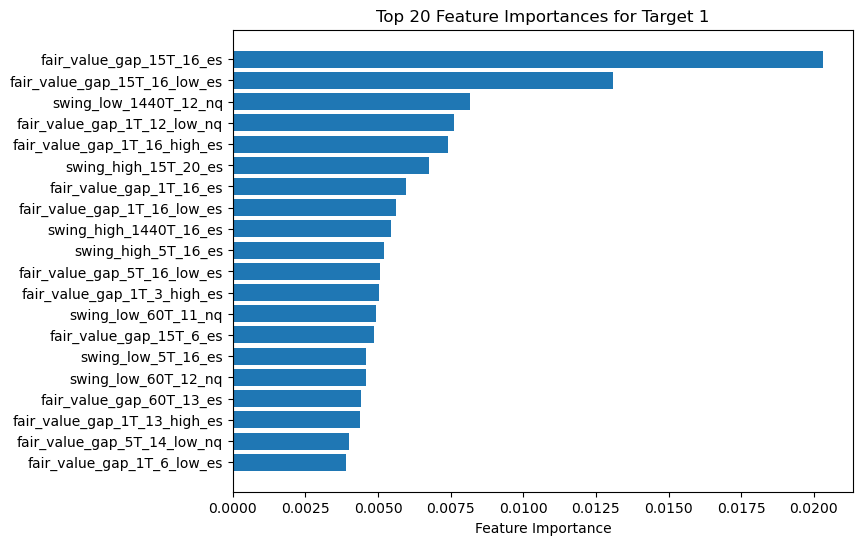

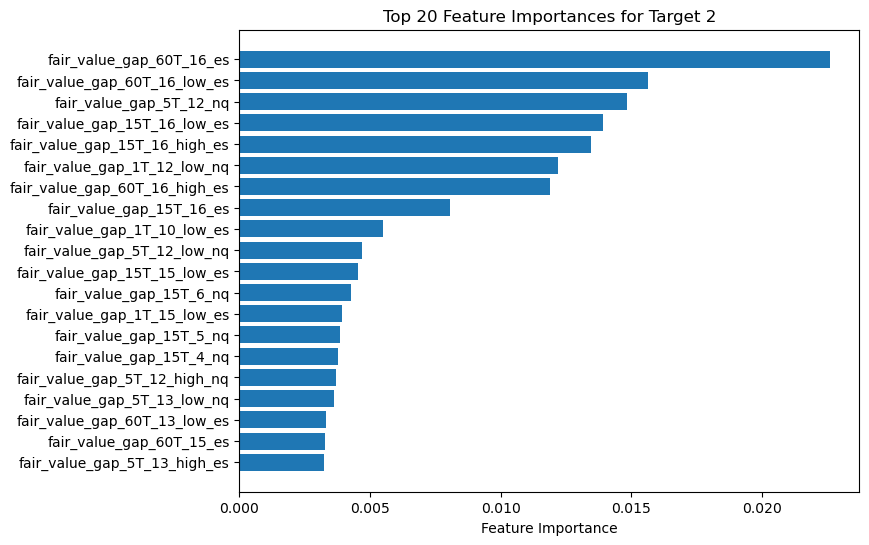

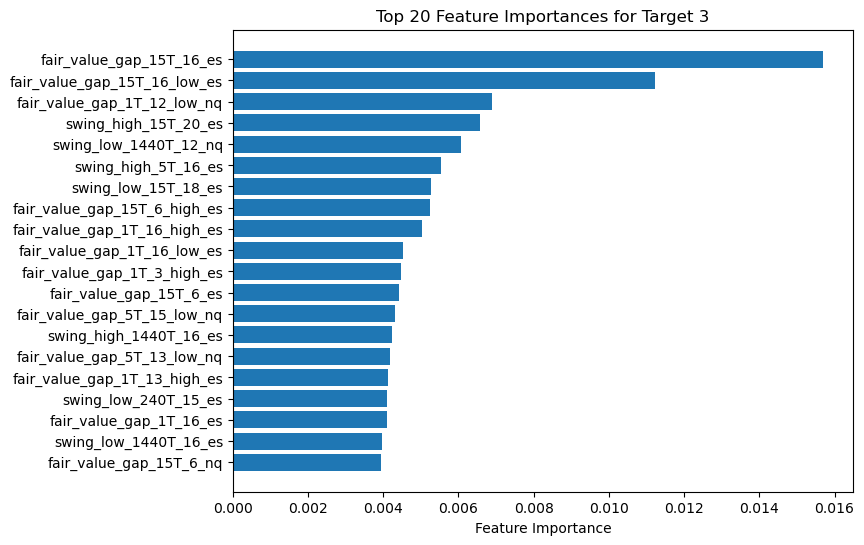

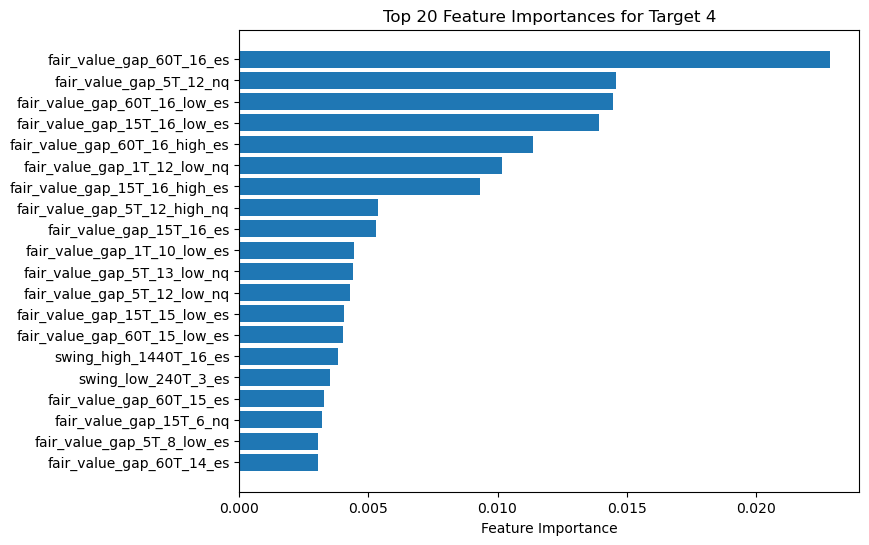

In [58]:
import matplotlib.pyplot as plt

# Assuming 'pipeline' is your trained pipeline with the MultiOutputRegressor
# and 'model' is the name of the MultiOutputRegressor step in the pipeline
multi_output_regressor = pipeline.named_steps['model']

# Assuming 'feature_names' is a list of names of the features used in training the model
feature_names = [c for c in df_final.columns if c not in target_cols]  # Replace with actual feature names

# Number of top features to display
num_top_features = 20

# Iterate through each target's fitted regressor and plot feature importances
for target_idx, regressor in enumerate(multi_output_regressor.estimators_):
    feature_importances = regressor.feature_importances_
    sorted_idx = feature_importances.argsort()[-num_top_features:]  # Select top 10 indexes
    
    plt.figure(figsize=(8, 6))
    plt.barh(range(len(sorted_idx)), feature_importances[sorted_idx])
    plt.yticks(range(len(sorted_idx)), [feature_names[i] for i in sorted_idx])
    plt.xlabel('Feature Importance')
    plt.title(f'Top {num_top_features} Feature Importances for Target {target_idx + 1}')
    plt.show()

In [36]:
X.shape

(4892, 1309)